# <center>5조</center>



####<center>target : 삼성전자 2020년 12월 30일 기준, 1년 후 주식 가격</center>

<center>이를 위해 2년 간의 데이터(2019~2020년)를 기반해서 일별 수익률을 우선 도출했습니다. 다만, t기 주가 및 수익률은 이전의 값들과 독립적이지 않기 때문에 단순히 이 값들로부터 bootstrap을 해서 1년 후의 주가 및 수익률을 구하는 것은 수익률들 간의 상관성을 고려하지 못한다는 한계가 있다고 판단했습니다. 이를 보정하기 위해 저희는 block size를 주 단위로 해서 moving block bootstrap을 진행했습니다. 그리고 이렇게 해서 얻은 수익률의 분포로부터 3만 개의 예상 수익률을 구했습니다. 마지막으로 중심극한정리에 따라 이 3만 개의 예상 수익률이 정규 분포를 따른다는 가정을 받아들여 normal distribution 하에서 하나의 예상 수익률을 무작위 추출했습니다. 그리고 이 값에 2020년 12월 30일의 종가를 곱해주어 1년 후의 삼성전자 주가의 예측치를 도출했습니다.</center>

# 1. Dependency

In [ ]:
#pip install pandas-datareader
!pip install arch

import pandas as pd
import pandas_datareader.data as pdr
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.style.use('ggplot')
import numpy as np
from arch.bootstrap import StationaryBootstrap, CircularBlockBootstrap, MovingBlockBootstrap


     |████████████████████████████████| 798kB 5.5MB/s 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 2. Data 수집, 전처리

In [ ]:
start = datetime(2019,1,4)
end = datetime(2021,1,3)
stock = '005930.KS'
df = pdr.DataReader(stock,'yahoo',start=start, end = end)
df = pd.DataFrame(data = df)
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-01-04,37600.0,36850.0,37450.0,37450.0,14108958.0,35645.027344
2019-01-07,38900.0,37800.0,38000.0,38750.0,12748997.0,36882.367188
2019-01-08,39200.0,37950.0,38000.0,38100.0,12756554.0,36263.699219
2019-01-09,39600.0,38300.0,38650.0,39600.0,17452708.0,37691.398438
2019-01-10,40150.0,39600.0,40000.0,39800.0,14731699.0,37881.761719


In [ ]:
#Close 제거
df = df.loc[:,['High', 'Low', 'Open', 'Volume', 'Adj Close']]

In [ ]:
df.tail()

,High,Low,Open,Volume,Adj Close
Date,,,,,
2020-12-24,78800.0,74000.0,74100.0,32502870.0,77800.0
2020-12-28,80100.0,78200.0,79000.0,40085044.0,78700.0
2020-12-29,78900.0,77300.0,78800.0,30339449.0,78300.0
2020-12-30,81300.0,77300.0,77400.0,29417421.0,81000.0
2021-01-04,84400.0,80200.0,81000.0,38655276.0,83000.0


In [ ]:
df['yield'] = df['Adj Close'].pct_change()*100

In [ ]:
df.head()

,High,Low,Open,Volume,Adj Close,yield
Date,,,,,,
2019-01-04,37600.0,36850.0,37450.0,14108958.0,35645.027344,NaN
2019-01-07,38900.0,37800.0,38000.0,12748997.0,36882.367188,3.471283
2019-01-08,39200.0,37950.0,38000.0,12756554.0,36263.699219,-1.677409
2019-01-09,39600.0,38300.0,38650.0,17452708.0,37691.398438,3.936993
2019-01-10,40150.0,39600.0,40000.0,14731699.0,37881.761719,0.505058


In [ ]:
stock_yield = df['yield']

In [ ]:
stock_yield.dropna()

Date
2019-01-07    3.471283
2019-01-08   -1.677409
2019-01-09    3.936993
2019-01-10    0.505058
2019-01-11    1.758803
                ...   
2020-12-24    5.277402
2020-12-28    1.156812
2020-12-29   -0.508259
2020-12-30    3.448276
2021-01-04    2.469136
Name: yield, Length: 491, dtype: float64

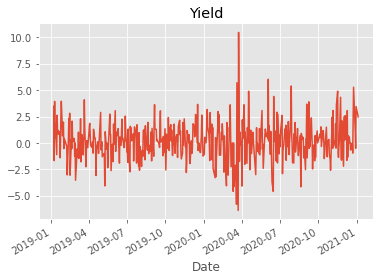

In [ ]:
stock_yield.plot(title='Yield')

# 3. 주가 예측 

  ### (1) moving block bootstrapping - 일별 수익률 

In [ ]:
from numpy.random import RandomState
rs = RandomState(47)

In [ ]:
mbs = MovingBlockBootstrap(5, stock_yield, random_state = rs)

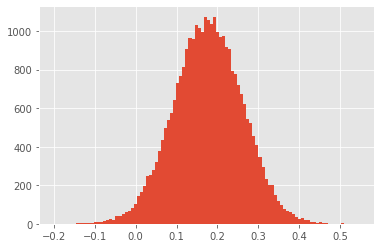

In [ ]:
def average_yield(x):
  return x.mean()
  
results = mbs.apply(average_yield, 30000)
plt.hist(results, bins=100)
plt.show()

In [ ]:
mu = results.mean()
stdv = results.std()
print(mu, stdv)

0.17729880002671053 0.08404512100840271


  ### (2) bootstrapping - 1년 후 주가

In [ ]:
criteria = df.loc['2020-12-30', 'Adj Close']
forecasts = []
for i in range(30000):    
    random_yield = np.random.normal(loc=mu, scale = stdv, size=260)
    forecast_yield = 1
    for j in random_yield:
      forecast_yield *= (1+j/100)
    forecasts.append(criteria*forecast_yield)
print(forecasts)

[127580.05396992662, 129969.44565212264, 127844.73101125458, 127136.98527491927, 132085.17367736108, 128521.75991439554, 126831.39317449403, 128319.48194168282, 127087.8315138227, 128783.43614169431, 128648.58244348131, 129638.2935791861, 131488.38939520626, 125257.83431574609, 131056.11276394488, 127633.69339049082, 126904.20502210876, 130545.45827236252, 128676.32907088622, 127788.02647624821, 128293.91038241806, 130472.63746188821, 128240.53476971215, 131744.8033399065, 128123.10957689618, 130012.56136394892, 130060.92151529297, 129237.50536126932, 129162.1143873237, 128157.05081635997, 131398.97706361697, 127484.64338376062, 127152.88096613492, 131866.30725972317, 127625.8827450066, 130863.81018821681, 129315.31208295719, 129064.01145038648, 128596.81574225542, 125503.94663300636, 127485.93399771547, 129386.4219532672, 124164.8161361825, 125911.77296274345, 126239.35775917563, 124744.45477456032, 127398.96237363736, 130955.84324147564, 129725.69259826791, 123904.95022197707, 128525

  ### (3) 예측치 도출

In [ ]:
df2 = pd.DataFrame(forecasts)
mean = df2.mean()
std = df2.std()
print(mean, std)

0    128358.713353
dtype: float64 0    1735.933561
dtype: float64


In [ ]:
np.random.seed(1023)
final_predict = np.random.normal(loc=mean, scale = std, size=1)
final_predict
print("1년 후 삼성주가 예측치는 {}원 입니다".format(round(final_predict[0]/100)*100))

1년 후 삼성주가 예측치는 128800원 입니다
